In [1]:
# we make N cells where cell n makes an excitatory synapse onto cell n+1
# the last, Nth cell in the network projects to the first cell

# Generic cell class

In [2]:
# splitting the BallAndStick class into 2 parts
# a generic cell class + that which is specific to the BallAndStick model

In [3]:
from neuron import h, gui
from neuron.units import ms, mV

In [4]:
h.load_file('stdrun.hoc')

1.0

In [5]:
# generic Cell class

class Cell:
    
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)

In [6]:
# ball and stick class

class BallAndStick(Cell):
    
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L= self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
        
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100 # axial resistance
            sec.cm = 1 # membrane capacitance
            
        self.soma.insert('hh')
        
        for seg in self.soma:
            seg.hh.gnabar = 0.12 # sodium conductance
            seg.hh.gkbar = 0.036 # potassium conductance
            seg.hh.gl = 0.0003 # leak conductance
            seg.hh.el = -54.3 # reversal potential
            
        # insert passive current in the dendrite
        self.dend.insert('pas')
        
        for seg in self.dend:
            seg.pas.g = 0.001
            seg.pas.e = -65

In [7]:
# the change of the BallAndStick class

# removal of the __init__ and __repr__ methods
# the specification of the name of the class
# the removal of the definition of self.all
# class declaration (to indicate that BallAndStick is a type of Cell)

# Adjusting position and orientation

In [8]:
# if we have more than one cell, we'd like to be able to position them

class Cell:
    
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        
        # New
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x,y,z)
        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    # New
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                              x - self.x + sec.x3d(i),
                              y - self.y + sec.y3d(i),
                              z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
        
    def _rotate_z(self, theta):
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [9]:
# rerun it
# ball and stick class

class BallAndStick(Cell):
    
    name = 'BallAndStick'
    
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L= self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
        
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100 # axial resistance
            sec.cm = 1 # membrane capacitance
            
        self.soma.insert('hh')
        
        for seg in self.soma:
            seg.hh.gnabar = 0.12 # sodium conductance
            seg.hh.gkbar = 0.036 # potassium conductance
            seg.hh.gl = 0.0003 # leak conductance
            seg.hh.el = -54.3 # reversal potential
            
        # insert passive current in the dendrite
        self.dend.insert('pas')
        
        for seg in self.dend:
            seg.pas.g = 0.001
            seg.pas.e = -65

In [10]:
# Let's create the cell
# specify x, y, z and theta in addition to the gid
mycell = BallAndStick(0, 0, 0, 0, 0)

In [11]:
# delete the test cell
del mycell

# Construct and position our cells

In [12]:
# parameter: N(number of cells), r(radius of the cirle-micron)

def create_n_BallAndStick(n, r):
    cells = []
    
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
        
    return cells

In [13]:
# create the cell
my_cells = create_n_BallAndStick(7, 50)

In [14]:
ps = h.PlotShape(True)
ps.show(0)

1.0

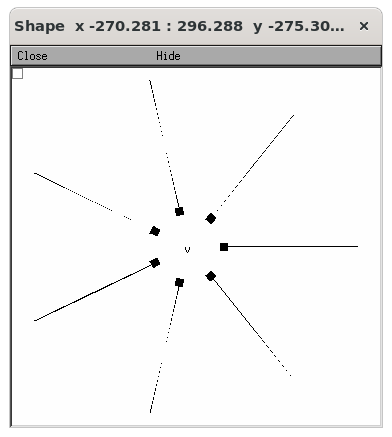

In [15]:
from IPython.display import Image
Image("Screenshot from 2023-07-11 10-25-05.png")

In [16]:
my_cells = create_n_BallAndStick(5, 50)

In [17]:
ps = h.PlotShape(True)
ps.show(0)

1.0

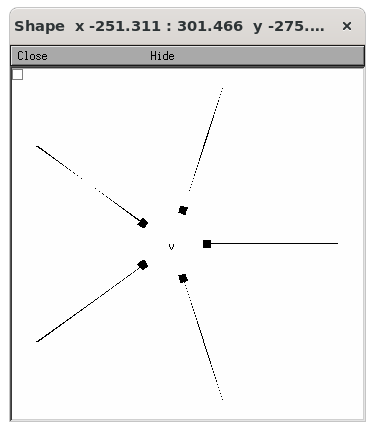

In [18]:
Image("Screenshot from 2023-07-11 10-27-16.png")

# A first synapse, and input via a NetStim

In [19]:
# instead of stimulating with a current electrode -> virtual synapse!

# event-based communication - NetCons
# when spike is detected, NetCon sends a message to a target(synapse on a postsynaptic cell)

# NetStim is a spike generator
# act like external input onto the synapse of a target cell

In [20]:
# t = 9 : NetStim object
# NetCon ms delay -> t = 10 : synaptic event

# it behaves like AMPA synapse

In [21]:
# make a new stimulator
stim = h.NetStim()

# attach it to a synapse in the middle of the dendrite of the first cell in the network
syn_ = h.ExpSyn(my_cells[0].dend(0.5))

stim.number = 1
stim.start = 9

ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04 # NetCon weight is a vector

In [22]:
# specify a time constant of 2ms
syn_.tau = 2 * ms

In [23]:
# tau specifies how quickly the currents decay
# exact value of the current depends on cell's membrane potential, synapse's reversal potential(syn_.e)

In [24]:
print('Reversal potential = {} mV'.format(syn_.e))

Reversal potential = 0.0 mV


# Running and plotting a simulation

## Recording

In [25]:
recording_cell = my_cells[0]

soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

## Simulating

In [26]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

## Plotting

In [27]:
%matplotlib inline

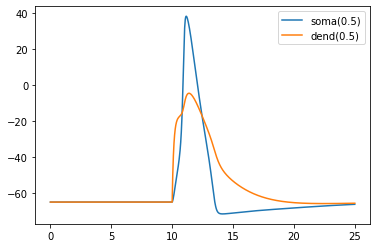

In [28]:
import matplotlib.pyplot as plt

plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

## Recording synaptic conductance

In [29]:
# we want to consider the time series of synaptic current
# so create a new Vector to monitor it

syn_i = h.Vector().record(syn_._ref_i)

In [30]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

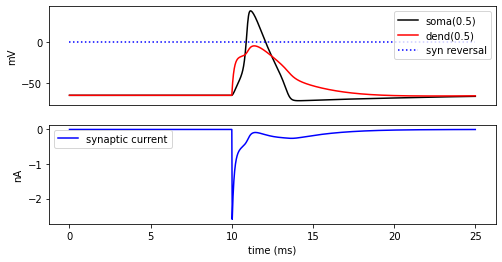

In [31]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(2, 1, 1)

soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
rev_plot = ax1.plot([t[0], t[-1]], [syn_.e, syn_.e], label='syn reversal', color='blue', linestyle=':')

ax1.legend()
ax1.set_ylabel('mV')
ax1.set_xticks([])

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')

ax2.legend()
ax2.set_ylabel(h.units('ExpSyn.i'))
ax2.set_xlabel('time (ms)')

plt.show()

# Connecting the cells

In [32]:
# we need to connect an axon from cell n to a synapse at the middle of the dendrite on cell n+1
# when the soma fires an action potential
# spike propagates down the axon and induces a synaptic event onto the dendrite of the target cell with some delay

In [33]:
syns = []
netcons = []

for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

In [34]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

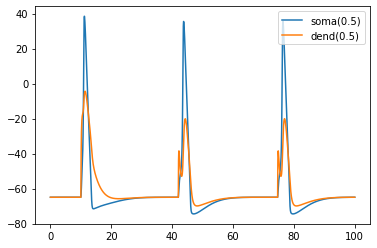

In [35]:
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')

plt.legend()
plt.show()

In [36]:
# our existing NetCons to record spike times in NEURON Vector objects using NetCon.record

spike_times = [h.Vector() for nc in netcons]

for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

In [37]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

In [38]:
for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

cell 0: [10.925000000099914, 43.55000000010134, 76.17500000010875]
cell 1: [17.450000000099543, 50.075000000102825, 82.70000000011024]
cell 2: [23.975000000099172, 56.60000000010431, 89.22500000011172]
cell 3: [30.5000000000988, 63.12500000010579, 95.7500000001132]
cell 4: [37.02500000009986, 69.65000000010727]


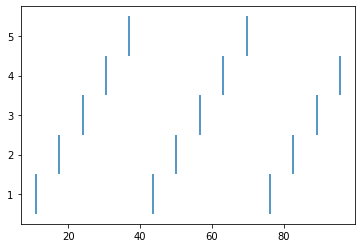

In [39]:
import matplotlib.pyplot as plt

plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(list(spike_times_vec), i + 0.5, i + 1.5)
    
plt.show()